In [2]:
from sklearn import datasets
import numpy as np

iris = datasets.load_iris()
X = iris.data[:, [2, 3]]
y = iris.target
print("Class labels", np.unique(y))

Class labels [0 1 2]


In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y) #stratifies keeps proportionality

print("labels count in y:", np.bincount(y))
print("labels count in y_train:", np.bincount(y_train))
print("labels count in y_test:", np.bincount(y_test))


labels count in y: [50 50 50]
labels count in y_train: [35 35 35]
labels count in y_test: [15 15 15]


In [4]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [5]:
from sklearn.linear_model import Perceptron
ppn = Perceptron(eta0=0.1, random_state=1)
ppn.fit(X_train_std, y_train)

ypred = ppn.predict(X_test_std)
print("Misclassified samples:", (y_test != ypred).sum())

Misclassified samples: 1


In [6]:
from sklearn.metrics import accuracy_score
print("Accuracy:", accuracy_score(y_test, ypred))

print("Accuracy:", ppn.score(X_test_std, y_test)) #score predicts and scores

Accuracy: 0.9777777777777777
Accuracy: 0.9777777777777777


In [7]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

# To check recent matplotlib compatibility
import matplotlib
from distutils.version import LooseVersion


def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('o', 's', '^', 'v', '<')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    lab = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    lab = lab.reshape(xx1.shape)
    plt.contourf(xx1, xx2, lab, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class examples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=f'Class {cl}', 
                    edgecolor='black')

    # highlight test examples
    if test_idx:
        # plot all examples
        X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c='none',
                    edgecolor='black',
                    alpha=1.0,
                    linewidth=1,
                    marker='o',
                    s=100, 
                    label='Test set')   

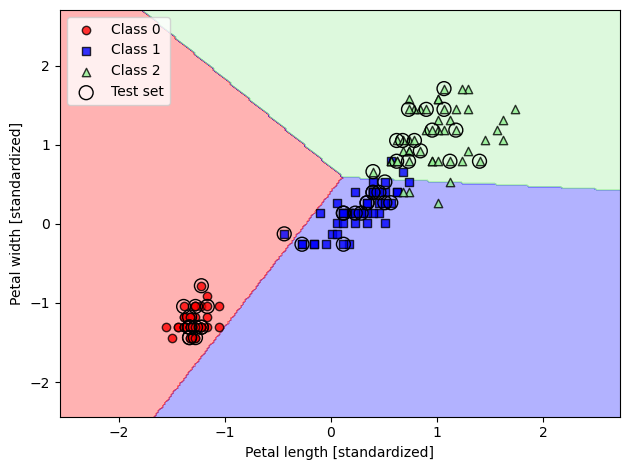

In [8]:
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

plot_decision_regions(X=X_combined_std, y=y_combined,
                      classifier=ppn, test_idx=range(105, 150))
plt.xlabel('Petal length [standardized]')
plt.ylabel('Petal width [standardized]')
plt.legend(loc='upper left')

plt.tight_layout()

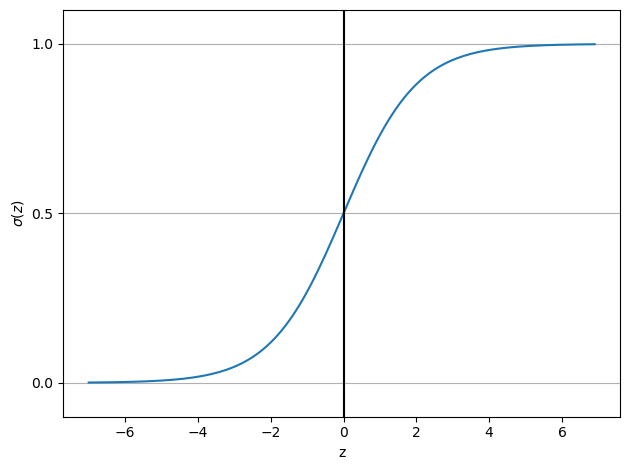

In [9]:
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

z = np.arange(-7, 7, 0.1)
sigma_z = sigmoid(z)

plt.plot(z, sigma_z)
plt.axvline(0.0, color='k')
plt.ylim(-0.1, 1.1)
plt.xlabel('z')
plt.ylabel('$\sigma (z)$')

# y axis ticks and gridline
plt.yticks([0.0, 0.5, 1.0])
ax = plt.gca()
ax.yaxis.grid(True)

plt.tight_layout()

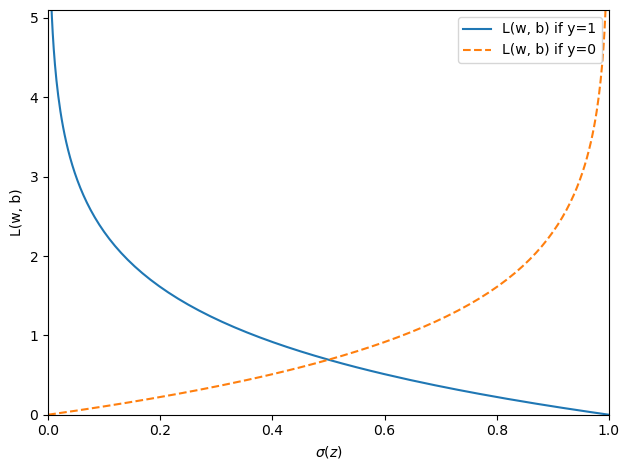

In [10]:

def loss_1(z):
    return - np.log(sigmoid(z))


def loss_0(z):
    return - np.log(1 - sigmoid(z))

z = np.arange(-10, 10, 0.1)
sigma_z = sigmoid(z)

c1 = [loss_1(x) for x in z]
plt.plot(sigma_z, c1, label='L(w, b) if y=1')

c0 = [loss_0(x) for x in z]
plt.plot(sigma_z, c0, linestyle='--', label='L(w, b) if y=0')

plt.ylim(0.0, 5.1)
plt.xlim([0, 1])
plt.xlabel('$\sigma(z)$')
plt.ylabel('L(w, b)')
plt.legend(loc='best')
plt.tight_layout()


In [11]:
class LogisticRegressionGD:
    ''' Gradient descent-based logistic regression classifier
    
    Paramters
    eta: float
        Learning rate (between 0 and 1)
    n_iter: int
        Passes over the training dataset
    random_state: int
        rng for random starting weights
        
    Attributes:
    w_: 1d array
        weights after fitting
    b_: scalar
        bias after fitting
    losses_: list
        Mean squared error loss function values in each epoch
    
    '''
    
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state
    
    def fit(self, X, y):
        '''
        Fit the training data
        Parameter:
        X: array, shape = [n_examples, n_features]
            training data with n_example rows, n_features columns
        y: array, shape = [n_examples]
            target values
            
        returns
        self: Instance of LogisticRegressionGD
        '''
        
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size = X.shape[1])
        self.b_ = np.float32(0.)
        self.losses_ = []
        
        for i in range(self.n_iter):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = (y - output)
            self.w_ += self.eta * 2*X.T.dot(errors) / X.shape[0]
            self.b_ += self.eta * 2*errors.mean()
            loss = -y.dot(np.log(output)) - ((1 - y).dot(np.log(1 - output))) / X.shape[0]
            self.losses_.append(loss)
        return self
    
    def net_input(self, X):
        #Calculate input
        return np.dot(X, self.w_) + self.b_
    
    def activation(self, X):
        #Compute linear activation
        return 1. / (1. + np.exp(-np.clip(X, -250, 250)))
        
    def predict(self, X):
        #return class label by returning 1 if net_input >= 0.5, 0 otherwise
        return np.where(self.net_input(X) >= 0.5, 1, 0)


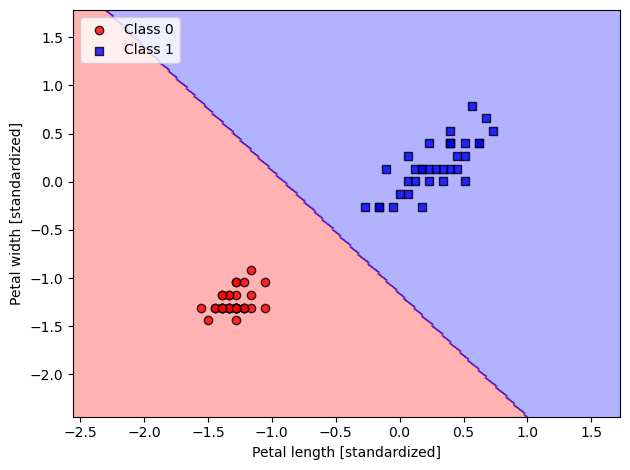

In [12]:
X_train_01_subset = X_train_std[(y_train == 0) | (y_train == 1)]
y_train_01_subset = y_train[(y_train == 0) | (y_train == 1)]

lrgd = LogisticRegressionGD(eta=0.3, n_iter=1000, random_state=1)
lrgd.fit(X_train_01_subset,
         y_train_01_subset)

plot_decision_regions(X=X_train_01_subset, 
                      y=y_train_01_subset,
                      classifier=lrgd)

plt.xlabel('Petal length [standardized]')
plt.ylabel('Petal width [standardized]')
plt.legend(loc='upper left')

plt.tight_layout()

/Users/ishaan/miniconda3/envs/LearningFromRaschka/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


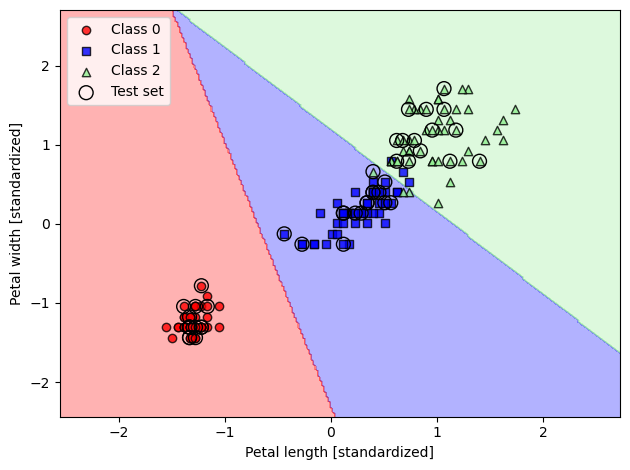

In [13]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(C=100.0, solver='lbfgs', multi_class='ovr')
lr.fit(X_train_std, y_train)
plot_decision_regions(X_combined_std, y_combined,
                      classifier=lr, test_idx=range(105, 150))
plt.xlabel('Petal length [standardized]')
plt.ylabel('Petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()

In [16]:
print(lr.predict_proba(X_test_std[:3, :]))
print(lr.predict_proba(X_test_std[:3, :]).argmax(axis=1))
lr.predict(X_test_std[:3, :])

[[6.63770505e-09 1.44747233e-01 8.55252760e-01]
 [8.34031210e-01 1.65968790e-01 3.20815954e-13]
 [8.48822884e-01 1.51177116e-01 2.57998350e-14]]
[2 0 0]


array([2, 0, 0])

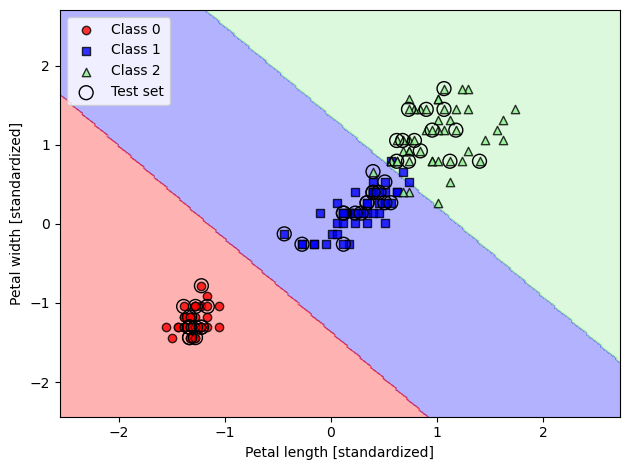

In [17]:
from sklearn.svm import SVC

svm = SVC(kernel='linear', C=1.0, random_state=1)
svm.fit(X_train_std, y_train)
plot_decision_regions(X_combined_std, y_combined,
                      classifier=svm, test_idx=range(105, 150))
plt.xlabel('Petal length [standardized]')
plt.ylabel('Petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()

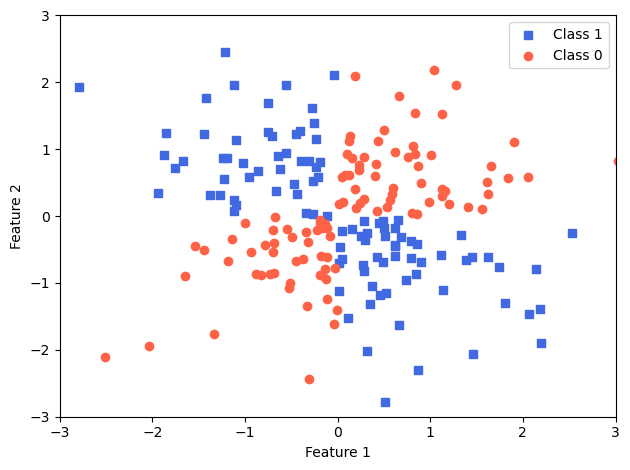

In [18]:
np.random.seed(1)
X_xor = np.random.randn(200, 2)
y_xor = np.logical_xor(X_xor[:, 0] > 0,
                       X_xor[:, 1] > 0)
y_xor = np.where(y_xor, 1, 0)

plt.scatter(X_xor[y_xor == 1, 0],
            X_xor[y_xor == 1, 1],
            c='royalblue',
            marker='s',
            label='Class 1')
plt.scatter(X_xor[y_xor == 0, 0],
            X_xor[y_xor == 0, 1],
            c='tomato',
            marker='o',
            label='Class 0')

plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

plt.legend(loc='best')
plt.tight_layout()

#No linear boundary so we need to use a kernel

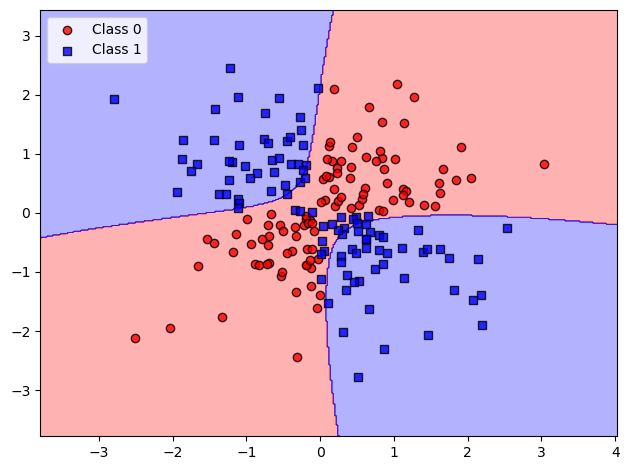

In [19]:

svm = SVC(kernel='rbf', random_state=1, gamma=0.10, C=10.0)
svm.fit(X_xor, y_xor)
plot_decision_regions(X_xor, y_xor,
                      classifier=svm)
plt.legend(loc='upper left')
plt.tight_layout()

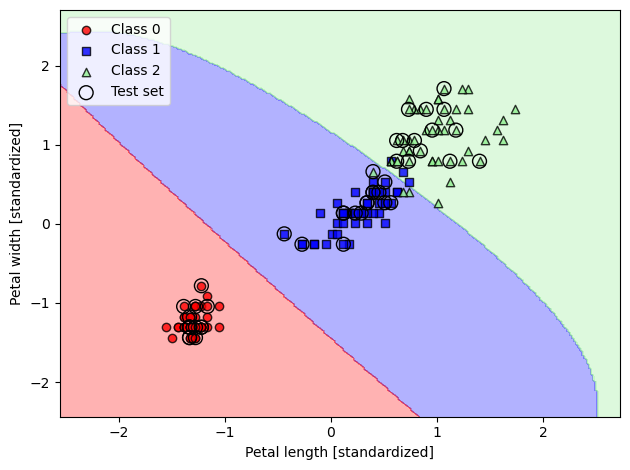

In [20]:
svm = SVC(kernel='rbf', random_state=1, gamma=0.2, C=1.0)
svm.fit(X_train_std, y_train)

plot_decision_regions(X_combined_std, y_combined,
                      classifier=svm, test_idx=range(105, 150))
plt.xlabel('Petal length [standardized]')
plt.ylabel('Petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
#plt.savefig('figures/03_15.png', dpi=300)
plt.show()

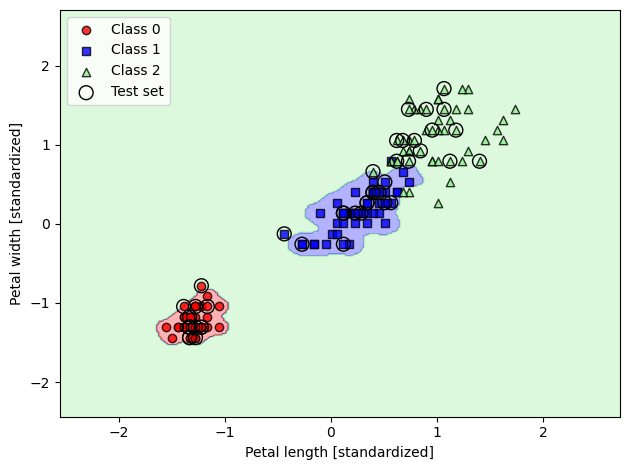

In [21]:
svm = SVC(kernel='rbf', random_state=1, gamma=100.0, C=1.0)
svm.fit(X_train_std, y_train)

plot_decision_regions(X_combined_std, y_combined, 
                      classifier=svm, test_idx=range(105, 150))
plt.xlabel('Petal length [standardized]')
plt.ylabel('Petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()

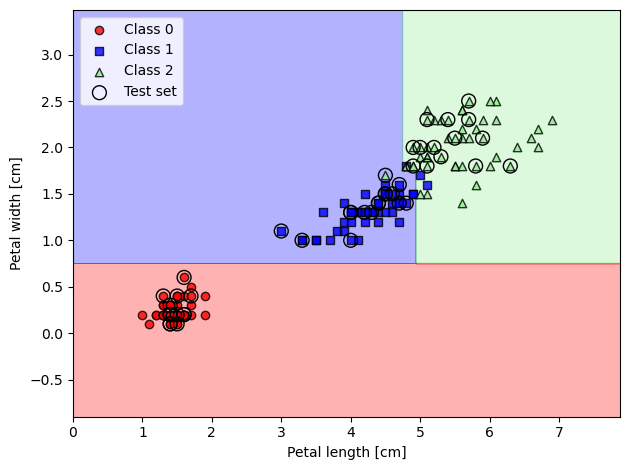

In [22]:
from sklearn.tree import DecisionTreeClassifier

tree_model = DecisionTreeClassifier(criterion='gini', 
                                    max_depth=4, 
                                    random_state=1)
tree_model.fit(X_train, y_train)

X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))
plot_decision_regions(X_combined, y_combined, 
                      classifier=tree_model,
                      test_idx=range(105, 150))

plt.xlabel('Petal length [cm]')
plt.ylabel('Petal width [cm]')
plt.legend(loc='upper left')
plt.tight_layout()

[Text(0.25, 0.9, 'Sepal width <= 0.75\ngini = 0.667\nsamples = 105\nvalue = [35, 35, 35]'),
 Text(0.125, 0.7, 'gini = 0.0\nsamples = 35\nvalue = [35, 0, 0]'),
 Text(0.1875, 0.8, 'True  '),
 Text(0.375, 0.7, 'Sepal length <= 4.75\ngini = 0.5\nsamples = 70\nvalue = [0, 35, 35]'),
 Text(0.3125, 0.8, '  False'),
 Text(0.25, 0.5, 'gini = 0.0\nsamples = 30\nvalue = [0, 30, 0]'),
 Text(0.5, 0.5, 'Sepal width <= 1.75\ngini = 0.219\nsamples = 40\nvalue = [0, 5, 35]'),
 Text(0.25, 0.3, 'Sepal length <= 4.95\ngini = 0.5\nsamples = 8\nvalue = [0, 4, 4]'),
 Text(0.125, 0.1, 'gini = 0.0\nsamples = 2\nvalue = [0, 2, 0]'),
 Text(0.375, 0.1, 'gini = 0.444\nsamples = 6\nvalue = [0, 2, 4]'),
 Text(0.75, 0.3, 'Sepal length <= 4.85\ngini = 0.061\nsamples = 32\nvalue = [0, 1, 31]'),
 Text(0.625, 0.1, 'gini = 0.444\nsamples = 3\nvalue = [0, 1, 2]'),
 Text(0.875, 0.1, 'gini = 0.0\nsamples = 29\nvalue = [0, 0, 29]')]

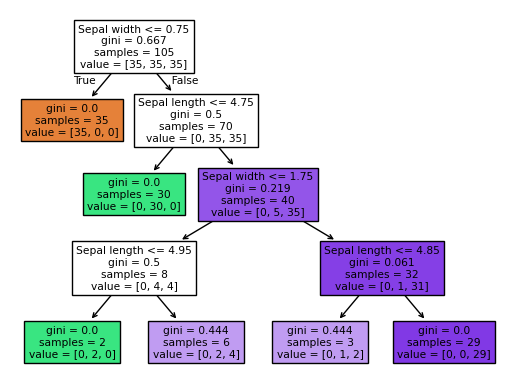

In [23]:
from sklearn import tree

feature_names = ['Sepal length', 'Sepal width',
                 'Petal length', 'Petal width']
tree.plot_tree(tree_model,
               feature_names=feature_names,
               filled=True)

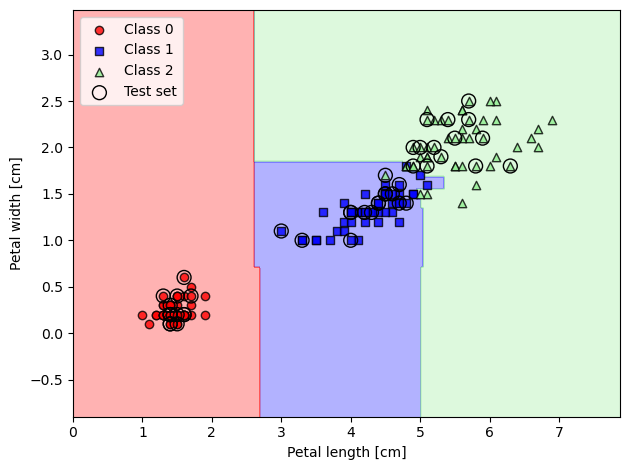

In [24]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=25, 
                                random_state=1,
                                n_jobs=2)
forest.fit(X_train, y_train)

plot_decision_regions(X_combined, y_combined, 
                      classifier=forest, test_idx=range(105, 150))

plt.xlabel('Petal length [cm]')
plt.ylabel('Petal width [cm]')
plt.legend(loc='upper left')
plt.tight_layout()

#combining many deep trees to create a random forest, each tree is individually weak

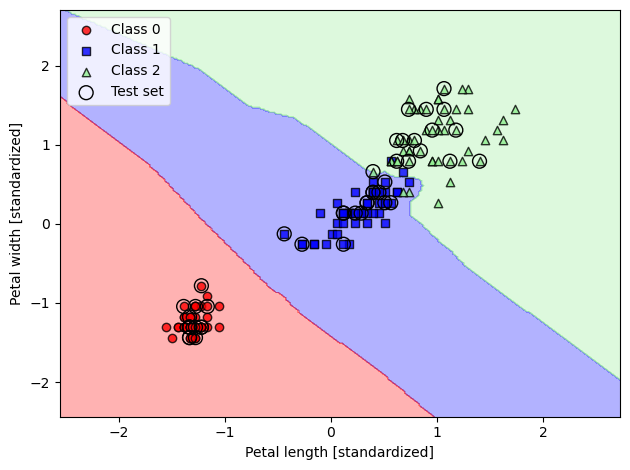

In [25]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5, 
                           p=2, 
                           metric='minkowski')
knn.fit(X_train_std, y_train)

plot_decision_regions(X_combined_std, y_combined, 
                      classifier=knn, test_idx=range(105, 150))

plt.xlabel('Petal length [standardized]')
plt.ylabel('Petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()